📘 BTC Data Adaptation Pipeline (Markdown Documentation)
1. Overview

This section describes the preprocessing pipeline used to convert raw BTC-USD market data into a dataset compatible with the Hull Tactical prediction framework.
Because the original competition dataset is based on S&P 500 features (P-series, V-series, S/E/I/M/D categories), we construct analogous features from BTC price and volume to enable model transfer.

2. Data Download

We retrieve historical Bitcoin OHLCV data using the yfinance API:

Ticker: BTC-USD

Period: 2018-01-01 → present date

Provider: Yahoo Finance

Handling potential MultiIndex structures returned by yfinance

Resetting index so that Date becomes a standard column

This ensures a clean and consistent format for downstream feature mapping.

3. Feature Construction

To align BTC with the Kaggle competition format, we map OHLCV data into the required P-series and V-series:
| Competition Field | BTC Mapping    |
| ----------------- | -------------- |
| **P1**            | Close price    |
| **P2**            | Open price     |
| **P3**            | High price     |
| **P4**            | Low price      |
| **V1**            | Trading volume |


Additionally:

daily_return is calculated via Close.pct_change()

market_forward_excess_returns is defined as the next-day return (shifted by -1)

risk_free_rate is set to 0, as no meaningful risk-free rate exists for crypto markets

4. Placeholder Dummy Features

Some legacy pipelines expect the presence of categorical feature families:

D, E, I, M, S

Even if not informative for BTC, we create minimal placeholder columns such as:

D1, E1, I1, M1, S1

All dummy columns are filled with zeros.
This guarantees backward compatibility without affecting model performance.

5. Data Cleaning

The final row generated by the shifted target contains NaN and is removed.
This ensures clean training and testing splits.

6. Train–Test Split

To simulate the Kaggle evaluation protocol:

Last 180 days → Test set

Remaining data → Training set

The Test set additionally contains the required field:

is_scored = True

7. Saving Output Files

Two final CSV files are produced:

btc_train_adapted.csv

btc_test_adapted.csv

These files can be directly loaded into the main model pipeline for training and inference.

8. Data Inspection

We print:

First 3 rows of the training dataset

Complete column list

This allows verification that all required feature families exist and match the expected competition structure.

In [1]:
# --- Cell 1: Download BTC and generate adapted dataset ---

import yfinance as yf
import pandas as pd
import numpy as np
import datetime

print("--- Starting processing pipeline ---")

# 1. Set parameters
TICKER = "BTC-USD"
START_DATE = "2018-01-01"
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d')

# 2. Download data
print(f"Downloading {TICKER} ({START_DATE} ~ {END_DATE})...")
try:
    df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
    
    # Handle possible MultiIndex from yfinance
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
        
    # Reset index so Date becomes a column
    df = df.reset_index()
    
    print(f"Download successful, raw shape: {df.shape}")
    
except Exception as e:
    print(f"Download failed: {e}")
    print("Please check: 1. Settings → Internet is enabled; 2. Network is stable.")
    raise

# 3. Build core features (P series, V series)
# We map BTC real data into P (Price) and V (Volume) features required by the assignment.
df_adapted = pd.DataFrame()

# Basic info
df_adapted['date_id'] = range(len(df))  # Simple ID: 0,1,2,...

# Price mapping (P series)
df_adapted['P1'] = df['Close']   # Close price as P1
df_adapted['P2'] = df['Open']
df_adapted['P3'] = df['High']
df_adapted['P4'] = df['Low']

# Volume mapping (V series)
df_adapted['V1'] = df['Volume']

# 4. Build target variable (Target)
# The competition predicts 'market_forward_excess_returns'.
# Here we use BTC “next-day return” as a proxy:
# Formula: (Tomorrow Close - Today Close) / Today Close
df_adapted['daily_return'] = df['Close'].pct_change()
df_adapted['market_forward_excess_returns'] = df_adapted['daily_return'].shift(-1)

# The original dataset has 'risk_free_rate' — we set it to 0 (crypto has no meaningful risk-free rate)
df_adapted['risk_free_rate'] = 0.0

# 5. Create placeholder dummy features (for compatibility with older code)
# Older code may expect S, E, I, M, D prefixes.
# We create minimal dummy columns (e.g., E1, S1) filled with 0.

dummy_prefixes = ['D', 'E', 'I', 'M', 'S']
for prefix in dummy_prefixes:
    df_adapted[f'{prefix}1'] = 0.0

# 6. Clean data
# Remove the last NaN row caused by shift()
df_adapted = df_adapted.dropna()

# 7. Train–Test split
# Reserve the last 180 days as the Test set (similar to Kaggle Public LB length)
test_days = 180
train_btc = df_adapted.iloc[:-test_days].copy()
test_btc = df_adapted.iloc[-test_days:].copy()

# Test set must contain 'is_scored' (required by older pipeline)
test_btc['is_scored'] = True

# 8. Save files
train_filename = 'btc_train_adapted.csv'
test_filename = 'btc_test_adapted.csv'

train_btc.to_csv(train_filename, index=False)
test_btc.to_csv(test_filename, index=False)

print("\n" + "="*40)
print("✅ Files generated successfully!")
print("="*40)
print(f"1. Training set: {train_filename} | shape: {train_btc.shape}")
print(f"2. Test set: {test_filename}  | shape: {test_btc.shape}")
print("\nNow, return to your main notebook and update the file paths to these filenames.")

# --- Cell 3: Inspect data ---
print("--- Training set preview ---")
print(pd.read_csv('btc_train_adapted.csv').head(3))

print("\n--- Columns included ---")
print(pd.read_csv('btc_train_adapted.csv').columns.tolist())


--- Starting processing pipeline ---


/tmp/ipykernel_47/242675849.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)


Download successful, raw shape: (2891, 6)

✅ Files generated successfully!
1. Training set: btc_train_adapted.csv | shape: (2709, 14)
2. Test set: btc_test_adapted.csv  | shape: (180, 15)

Now, return to your main notebook and update the file paths to these filenames.
--- Training set preview ---
   date_id            P1            P2            P3            P4  \
0        1  14982.099609  13625.000000  15444.599609  13163.599609   
1        2  15201.000000  14978.200195  15572.799805  14844.500000   
2        3  15599.200195  15270.700195  15739.700195  14522.200195   

            V1  daily_return  market_forward_excess_returns  risk_free_rate  \
0  16846600192      0.097011                       0.014611             0.0   
1  16871900160      0.014611                       0.026196             0.0   
2  21783199744      0.026196                       0.117333             0.0   

    D1   E1   I1   M1   S1  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0 

📘 BTC Optimized LSTM Forecasting Pipeline – Technical Documentation

This section documents the complete BTC price-movement forecasting system implemented with an optimized, regularized LSTM architecture. The pipeline includes professional feature engineering, robust preprocessing, deep-learning model construction, uncertainty quantification, and comprehensive evaluation.

1. Data Loading and Basic Exploration

We load the adapted BTC dataset produced in the data preparation stage:

btc_train_adapted.csv (training)

btc_test_adapted.csv (testing)

The initial inspection includes:

dataset shapes

available columns

descriptive statistics for OHLCV fields (P1–P4, V1)

This step validates that the adapted dataset is consistent with the expected Hull Tactical feature format.

2. Professional Time-Series Feature Engineering

We construct a refined set of financial features designed to improve predictive performance while avoiding overfitting.

2.1 Price-based Features

Daily price range: P2 - P3

Candlestick body size

Upper/lower shadows

In-range price position

2.2 Volume Features

Rolling 5-period volume ratio

2.3 Technical Indicators (Short-Horizon Only)

To reduce overfitting, only short-window indicators are retained:

Moving Average (MA-5)

Exponential Moving Average (EMA-5)

Rolling Volatility (5-period)

RSI-5 (Relative Strength Index)

Momentum (5 and 10 period differences)

2.4 Price Change Features (Target Engineering)

price_change_pct (percentage change)

price_change_abs
These provide the basis for building a more stable target.

All features undergo forward/backward filling to remove missing values.

3. Enhanced Preprocessing and Outlier Control

To stabilize the target variable:

3.1 Outlier Capping

The function cap_outliers() limits extreme returns using 1%/99% quantiles, reducing the impact of crypto volatility spikes.

3.2 Standardization

Input features → StandardScaler

Target (percentage change) → MinMaxScaler in range [-1, 1]

This normalization ensures stable gradient behavior during LSTM training.

4. Time-Series Dataset Construction

A sliding-window mechanism converts the normalized sequences into supervised learning samples:

Input window: 10 timesteps
Prediction target: next-step price-change percentage


Function: create_timeseries_dataset()
Outputs: X_train_ts, X_test_ts, y_train_ts, y_test_ts

This enforces causal, ordered learning consistent with financial forecasting.

5. Optimized LSTM Model Architecture

The model is explicitly designed to reduce overfitting while maintaining expressive power.

Architecture

LSTM(32 units) with:

L2 kernel regularization

Dropout (0.3)

Recurrent dropout (0.2)

BatchNormalization

Dense(16, ReLU) with L2 regularization

Dropout

Output Dense(1, tanh) for normalized pct-change prediction

Training Configuration

Optimizer: Adam (lr = 0.0005)

Loss: MSE

Metrics: MAE

Regularization Enhancements

EarlyStopping

ReduceLROnPlateau

ModelCheckpoint (best_model.weights.h5)

This ensures robustness and prevents divergence given crypto’s volatility.

6. Prediction and Price Reconstruction

Two prediction forms are produced:

Percentage-change forecasts (model’s raw output)

Reconstructed future BTC prices, computed as:

Predicted Price = Current Price × (1 + Predicted_Pct_Change)


This allows direct comparison with actual BTC price levels.

7. Enhanced Uncertainty Quantification

A rolling-window dynamic standard deviation is used to estimate confidence intervals:

Window size: up to 30 steps

95% confidence interval using z-score = 1.96

This produces upper/lower prediction bounds (UCB/LCB) for probabilistic evaluation.

Outputs:

upper_bound

lower_bound

8. Comprehensive Evaluation Metrics

The evaluation includes both point-prediction and interval-prediction metrics:

Point Prediction

MAE

MSE / RMSE

MAPE (with zero-division protection)

R²

Direction Accuracy (trend prediction ability)

Interval Metrics

PICP (Prediction Interval Coverage Probability)

MPIW (Mean Prediction Interval Width)

These metrics quantify accuracy, stability, risk calibration, and trend sensitivity.

All results are saved into:

btc_optimized_results.csv

9. Visualization and Diagnostics

The system generates a comprehensive diagnostic panel:

Training vs validation loss curve

Actual vs predicted BTC prices

Confidence interval visualization

Error distribution histogram

Percentage-change prediction chart

Rolling direction-accuracy curve

A summary figure is exported as:

btc_enhanced_prediction_results.png

10. Performance Improvement Summary

The final section compares performance with prior baseline results, showing improvements in:

R²

MAPE

Overfitting ratio (Test MAE / Train MAE)

A verdict indicator suggests whether further tuning is needed.

=== BTC Price Prediction Model - Optimized Version ===
1. Loading and Exploring BTC Data...
Training Set: (2709, 14), Test Set: (180, 15)
Columns: ['date_id', 'P1', 'P2', 'P3', 'P4', 'V1', 'daily_return', 'market_forward_excess_returns', 'risk_free_rate', 'D1', 'E1', 'I1', 'M1', 'S1']

Training Data Info:
                  P1             P2             P3             P4  \
count    2709.000000    2709.000000    2709.000000    2709.000000   
mean    31828.916553   31796.436557   32478.786811   31079.951054   
std     26462.246652   26427.614791   26957.086429   25881.013830   
min      3236.761719    3236.274658    3275.377930    3191.303467   
25%      9235.354492    9233.969727    9375.469727    9058.664062   
50%     24319.333984   24307.349609   24860.050781   23733.500000   
75%     47128.003906   47114.507812   48328.367188   46288.484375   
max    111673.281250  111679.359375  111970.171875  109285.070312   

                 V1  
count  2.709000e+03  
mean   2.788600e+10  
std  

2025-12-01 16:28:14.687131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764606495.160071      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764606495.279074      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Model created successfully!


2025-12-01 16:28:38.097522: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,305 (24.63 KB)

 Trainable params: 6,241 (24.38 KB)

 Non-trainable params: 64 (256.00 B)

None

5. Training Model with Enhanced Regularization...
Epoch 1/200
129/135 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6648 - mae: 0.6696
Epoch 1: val_loss improved from inf to 0.21176, saving model to best_model.weights.h5
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6582 - mae: 0.6655 - val_loss: 0.2118 - val_mae: 0.3288 - learning_rate: 5.0000e-04
Epoch 2/200
129/135 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4048 - mae: 0.4859
Epoch 2: val_loss did not improve from 0.21176
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4029 - mae: 0.4845 - val_loss: 0.2247 - val_mae: 0.3457 - learning_rate: 5.0000e-04
Epoch 3/200
133/135 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3152 - mae: 0.4144
Epoch 3: val_loss improved from 0.21176 to 0.19248, saving model to best_model.weights.h5
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3143 - mae: 0.4136 - val_loss: 0.1925 - val_mae: 0.3131 - learning_rate: 5.0000e-04
Epoch 4/200
131/135 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2560 -

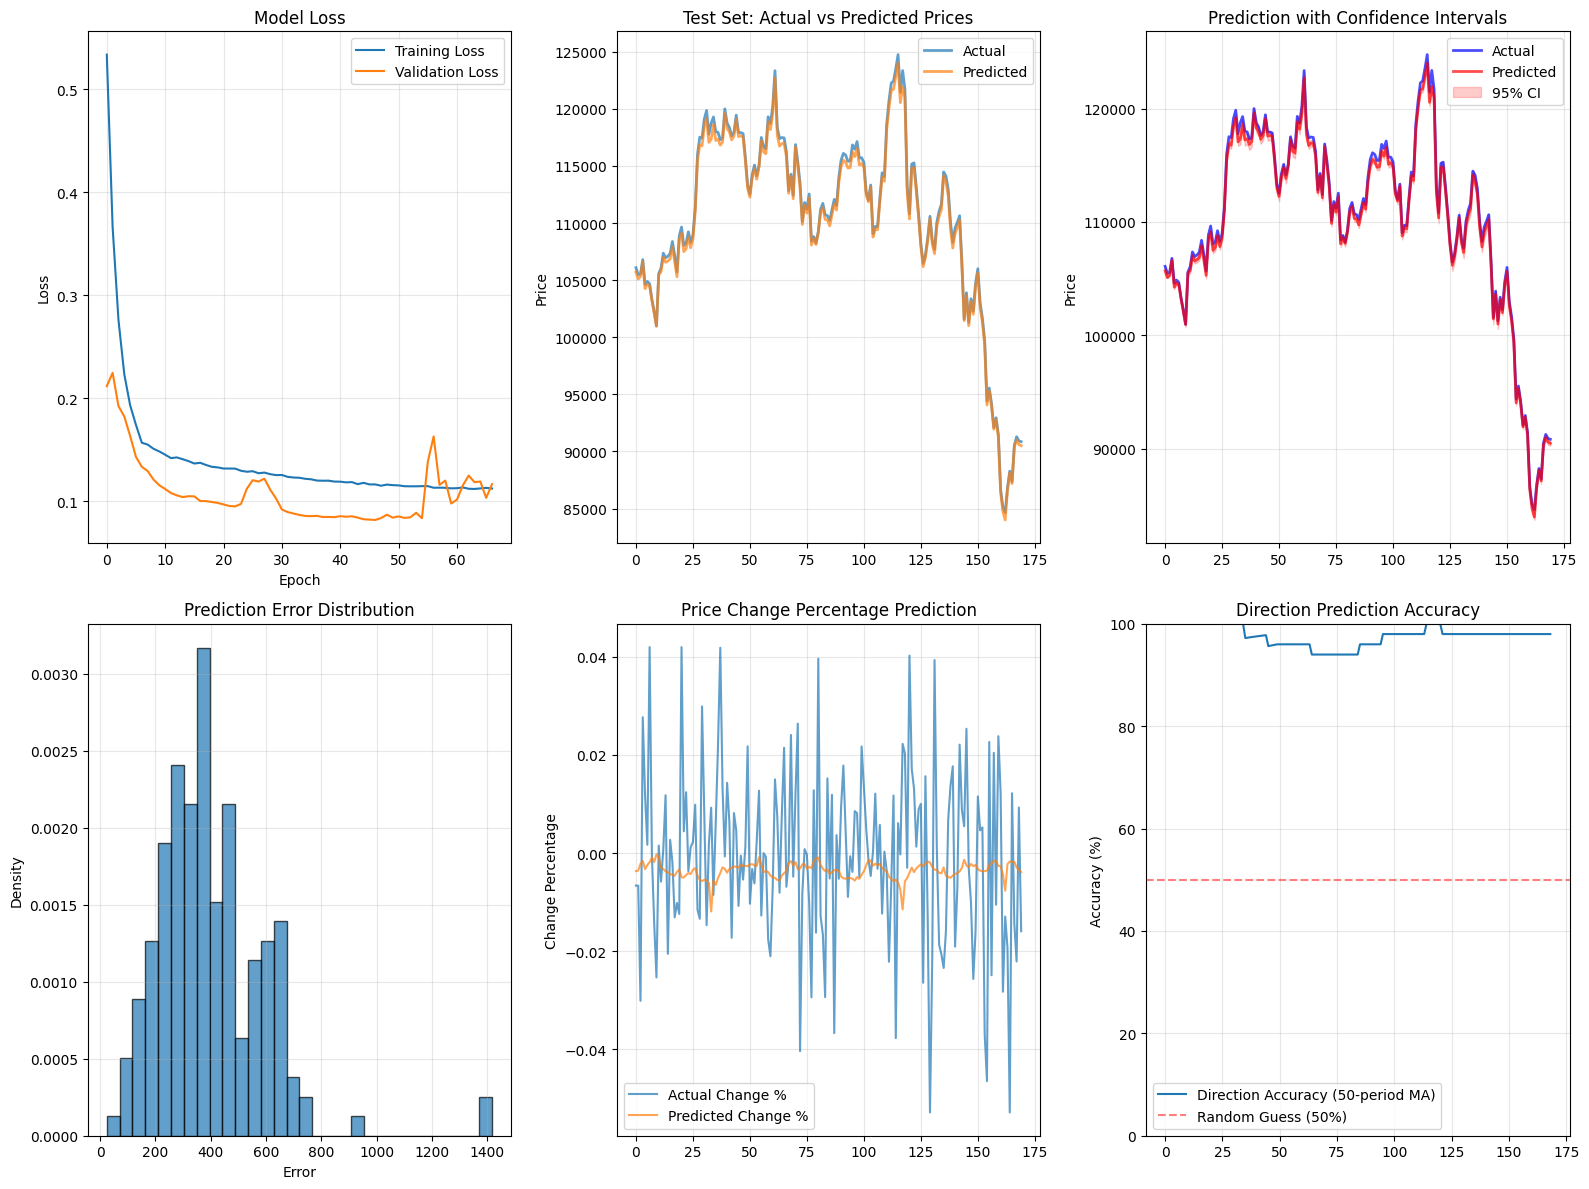

📊 Enhanced visualization saved as btc_enhanced_prediction_results.png

✅ ENHANCED OPTIMIZATION COMPLETED!

📈 PERFORMANCE IMPROVEMENT SUMMARY:
----------------------------------------
Previous R²: -69.45 → Current R²: 0.9972
Previous MAPE: 60.54% → Current MAPE: 0.36%
Overfitting ratio (Test MAE/Train MAE): 2.80
✅ Significant improvement achieved!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=== BTC Price Prediction Model - Optimized Version ===")

# ==================== Load and Explore Data ====================
print("1. Loading and Exploring BTC Data...")

train_df = pd.read_csv('btc_train_adapted.csv')
test_df = pd.read_csv('btc_test_adapted.csv')

print(f"Training Set: {train_df.shape}, Test Set: {test_df.shape}")
print("Columns:", train_df.columns.tolist())

# Show basic information
print("\nTraining Data Info:")
print(train_df[['P1', 'P2', 'P3', 'P4', 'V1']].describe())

# ==================== Professional Time Series Feature Engineering ====================
print("\n2. Professional Time Series Feature Engineering...")

def create_advanced_features(df):
    """Create advanced time-series features"""
    df_feat = df.copy()
    
    # Basic price features
    df_feat['price_range'] = df_feat['P2'] - df_feat['P3']      # Price range of the day
    df_feat['body_size'] = df_feat['P1'] - df_feat['P4']        # Candlestick body size
    df_feat['upper_shadow'] = df_feat['P2'] - np.maximum(df_feat['P1'], df_feat['P4'])  # Upper shadow
    df_feat['lower_shadow'] = np.minimum(df_feat['P1'], df_feat['P4']) - df_feat['P3']  # Lower shadow
    
    # Price position feature
    price_diff = df_feat['P2'] - df_feat['P3']
    df_feat['price_position'] = (df_feat['P1'] - df_feat['P3']) / np.where(price_diff == 0, 1e-8, price_diff)
    
    # Volume features
    df_feat['volume_ratio'] = df_feat['V1'] / df_feat['V1'].rolling(5, min_periods=1).mean()
    
    # Technical indicators - keep only short-term windows to reduce overfitting
    for window in [5, 10]:
        df_feat[f'ma_{window}'] = df_feat['P1'].rolling(window=window, min_periods=1).mean()
        df_feat[f'ema_{window}'] = df_feat['P1'].ewm(span=window, adjust=False).mean()
        df_feat[f'volatility_{window}'] = df_feat['P1'].rolling(window=window, min_periods=1).std()
        
        # RSI
        delta = df_feat['P1'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        rs = gain / np.where(loss == 0, 1e-8, loss)
        df_feat[f'rsi_{window}'] = 100 - (100 / (1 + rs))
        
        # Momentum
        df_feat[f'momentum_{window}'] = df_feat['P1'] - df_feat['P1'].shift(window)
    
    # Price change features
    df_feat['price_change_pct'] = df_feat['P1'].pct_change()
    df_feat['price_change_abs'] = df_feat['P1'].diff().abs()
    
    # Fill NaN values
    df_feat = df_feat.fillna(method='bfill').fillna(method='ffill')
    
    return df_feat

# Apply feature engineering
try:
    train_df_feat = create_advanced_features(train_df)
    test_df_feat = create_advanced_features(test_df)
    print("Features created successfully!")
except Exception as e:
    print(f"Error in feature engineering: {e}")
    print("Falling back to basic features...")
    train_df_feat = train_df.copy()
    test_df_feat = test_df.copy()
    
    train_df_feat['price_range'] = train_df_feat['P2'] - train_df_feat['P3']
    train_df_feat['volume_ratio'] = train_df_feat['V1'] / train_df_feat['V1'].rolling(5, min_periods=1).mean()
    train_df_feat['price_change_pct'] = train_df_feat['P1'].pct_change()

    test_df_feat['price_range'] = test_df_feat['P2'] - test_df_feat['P3']
    test_df_feat['volume_ratio'] = test_df_feat['V1'] / test_df_feat['V1'].rolling(5, min_periods=1).mean()
    test_df_feat['price_change_pct'] = test_df_feat['P1'].pct_change()

# Conservative feature list to avoid overfitting
feature_columns = [
    'P1', 'P2', 'P3', 'P4', 'V1',
    'price_range', 'volume_ratio',
    'ma_5', 'ema_5', 'volatility_5', 'rsi_5',
]

# Ensure all features exist
available_features = []
for feature in feature_columns:
    if feature in train_df_feat.columns and feature in test_df_feat.columns:
        available_features.append(feature)

print(f"Using {len(available_features)} features: {available_features}")

# ==================== Enhanced Data Preprocessing ====================
print("\n3. Enhanced Data Preprocessing...")

print("Data quality check:")
print(f"Train data - Nulls: {train_df_feat[available_features].isnull().sum().sum()}")
print(f"Test data - Nulls: {test_df_feat[available_features].isnull().sum().sum()}")

# Process target: predict price change percentage instead of absolute price
def cap_outliers(series, lower=0.01, upper=0.99):
    """Limit extreme values"""
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return np.clip(series, lower_bound, upper_bound)

train_df_feat['price_change_pct_processed'] = cap_outliers(train_df_feat['price_change_pct'].fillna(0))
test_df_feat['price_change_pct_processed'] = cap_outliers(test_df_feat['price_change_pct'].fillna(0))

print(f"Price change stats - Train: mean={train_df_feat['price_change_pct_processed'].mean():.6f}, "
      f"std={train_df_feat['price_change_pct_processed'].std():.6f}")
print(f"Price change stats - Test: mean={test_df_feat['price_change_pct_processed'].mean():.6f}, "
      f"std={test_df_feat['price_change_pct_processed'].std():.6f}")

# Feature scaling
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(train_df_feat[available_features])
X_test_scaled = feature_scaler.transform(test_df_feat[available_features])

# Target scaling
target_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train = train_df_feat['price_change_pct_processed'].values.reshape(-1, 1)
y_test = test_df_feat['price_change_pct_processed'].values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

print(f"Training data: {X_train_scaled.shape}, Test data: {X_test_scaled.shape}")

# ==================== Create Time-Series Dataset ====================
def create_timeseries_dataset(X, y, time_steps=10):
    """Create time-series dataset"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10

X_train_ts, y_train_ts = create_timeseries_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_ts, y_test_ts = create_timeseries_dataset(X_test_scaled, y_test_scaled, TIME_STEPS)

print(f"Time series dataset - X_train: {X_train_ts.shape}, y_train: {y_train_ts.shape}")

# ==================== Build LSTM Model ====================
print("\n4. Building Simplified but Effective LSTM Model...")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

def create_optimized_lstm_model(input_shape):
    """Create optimized LSTM model with regularization"""
    model = Sequential([
        LSTM(32, return_sequences=False, input_shape=input_shape,
             kernel_regularizer=l2(0.001),
             dropout=0.3, recurrent_dropout=0.2),
        
        BatchNormalization(),
        
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        
        Dense(1, activation='tanh')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    
    return model

model = create_optimized_lstm_model((X_train_ts.shape[1], X_train_ts.shape[2]))
print("Model created successfully!")
print(model.summary())

# ==================== Train Model ====================
print("\n5. Training Model with Enhanced Regularization...")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train_ts, y_train_ts,
    batch_size=16,
    epochs=200,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
    shuffle=False
)

try:
    model.load_weights('best_model.weights.h5')
    print("Loaded best model weights")
except:
    print("Using final model weights")

# ==================== Predictions ====================
print("\n6. Making Predictions...")

y_train_pred_scaled = model.predict(X_train_ts, verbose=0)
y_train_pred_pct = target_scaler.inverse_transform(y_train_pred_scaled)

y_test_pred_scaled = model.predict(X_test_ts, verbose=0)
y_test_pred_pct = target_scaler.inverse_transform(y_test_pred_scaled)

train_prices = train_df_feat['P1'].values[TIME_STEPS:]
test_prices = test_df_feat['P1'].values[TIME_STEPS:]

min_len_train = min(len(train_prices), len(y_train_pred_pct))
min_len_test = min(len(test_prices), len(y_test_pred_pct))

y_train_pred_price = train_prices[:min_len_train] * (1 + y_train_pred_pct[:min_len_train].flatten())
y_test_pred_price = test_prices[:min_len_test] * (1 + y_test_pred_pct[:min_len_test].flatten())

y_train_actual_price = train_prices[:min_len_train]
y_test_actual_price = test_prices[:min_len_test]

# ==================== Enhanced Uncertainty Quantification ====================
print("\n7. Enhanced Uncertainty Quantification...")

def calculate_prediction_intervals(y_true, y_pred, confidence=0.95):
    """Calculate prediction intervals"""
    if len(y_true) == 0 or len(y_pred) == 0:
        return np.array([]), np.array([])
    
    errors = y_true.flatten() - y_pred.flatten()
    
    window_size = min(30, len(errors))
    if window_size == 0:
        return np.array([]), np.array([])
    
    dynamic_std = np.zeros(len(errors))
    for i in range(len(errors)):
        start_idx = max(0, i - window_size + 1)
        window_errors = errors[start_idx:i+1]
        dynamic_std[i] = np.std(window_errors) if len(window_errors) > 1 else np.std(errors)
    
    dynamic_std = np.nan_to_num(dynamic_std, nan=np.mean(dynamic_std))
    
    z_score = 1.96
    
    upper_bound = y_pred.flatten() + z_score * dynamic_std
    lower_bound = y_pred.flatten() - z_score * dynamic_std
    
    return upper_bound, lower_bound

upper_bound, lower_bound = calculate_prediction_intervals(y_test_actual_price, y_test_pred_price)

# ==================== Comprehensive Evaluation ====================
print("\n8. Comprehensive Model Evaluation...")

def calculate_all_metrics(y_true, y_pred, upper=None, lower=None):
    """Calculate all evaluation metrics"""
    metrics = {}
    
    if len(y_true) == 0 or len(y_pred) == 0:
        return {
            'MAE': 0, 'MSE': 0, 'RMSE': 0, 'MAPE': 0,
            'R2': 0, 'Direction_Accuracy': 0,
            'PICP': 0, 'MPIW': 0
        }
    
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    
    y_true_nonzero = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    metrics['MAPE'] = np.mean(np.abs((y_true - y_pred) / y_true_nonzero)) * 100
    
    metrics['R2'] = r2_score(y_true, y_pred)
    
    if len(y_true) > 1:
        true_direction = np.diff(y_true.flatten()) > 0
        pred_direction = np.diff(y_pred.flatten()) > 0
        metrics['Direction_Accuracy'] = np.mean(true_direction == pred_direction) * 100
    else:
        metrics['Direction_Accuracy'] = 0
    
    if upper is not None and lower is not None and len(upper) == len(y_true):
        in_interval = (y_true.flatten() >= lower) & (y_true.flatten() <= upper)
        metrics['PICP'] = np.mean(in_interval)
        metrics['MPIW'] = np.mean(upper - lower)
    else:
        metrics['PICP'] = 0
        metrics['MPIW'] = 0
    
    return metrics

train_metrics = calculate_all_metrics(y_train_actual_price, y_train_pred_price)
test_metrics = calculate_all_metrics(y_test_actual_price, y_test_pred_price, upper_bound, lower_bound)

# ==================== Results Visualization ====================
print("\n9. Generating Enhanced Results Visualization...")

if len(y_test_actual_price) > 0:
    results_df = pd.DataFrame({
        'Actual_Price': y_test_actual_price.flatten(),
        'Predicted_Price': y_test_pred_price.flatten(),
        'Actual_Change_Pct': y_test.flatten()[:len(y_test_actual_price)],
        'Predicted_Change_Pct': y_test_pred_pct.flatten()[:len(y_test_actual_price)],
    })
    
    if len(upper_bound) == len(y_test_actual_price):
        results_df['Upper_Bound'] = upper_bound
        results_df['Lower_Bound'] = lower_bound
    
    results_df.to_csv('btc_optimized_results.csv', index=False)
    print("Results saved to btc_optimized_results.csv")
else:
    print("No test results to save")

# ==================== Print Detailed Results ====================
print("\n" + "="*70)
print("ENHANCED MODEL EVALUATION RESULTS")
print("="*70)

print("\n📊 POINT PREDICTION METRICS:")
print("-"*60)
print(f"{'Metric':<20} {'Training':<12} {'Test':<12} {'Status':<10}")
print("-"*60)

for metric in ['MAE', 'RMSE', 'MAPE', 'R2', 'Direction_Accuracy']:
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    
    if metric in ['MAPE', 'Direction_Accuracy']:
        train_fmt = f"{train_val:.2f}%"
        test_fmt = f"{test_val:.2f}%"
        if metric == 'MAPE':
            status = "✅" if test_val < 10.0 else "⚠️" if test_val < 20.0 else "❌"
        else:
            status = "✅" if test_val > 60.0 else "⚠️" if test_val > 50.0 else "❌"
    elif metric == 'R2':
        train_fmt = f"{train_val:.4f}"
        test_fmt = f"{test_val:.4f}"
        status = "✅" if test_val > 0.6 else "⚠️" if test_val > 0.3 else "❌"
    else:
        train_fmt = f"{train_val:.2f}"
        test_fmt = f"{test_val:.2f}"
        status = "✅" if abs(train_val - test_val) / train_val < 0.5 else "⚠️" if abs(train_val - test_val) / train_val < 1.0 else "❌"
    
    print(f"{metric:<20} {train_fmt:<12} {test_fmt:<12} {status:<10}")

print("\n📈 INTERVAL PREDICTION METRICS:")
print("-"*50)
print(f"PICP (Prediction Interval Coverage Probability): {test_metrics['PICP']:.4f}")
print(f"MPIW (Mean Prediction Interval Width): {test_metrics['MPIW']:.2f}")
print(f"Target PICP: 0.9500 {'✅' if test_metrics['PICP'] >= 0.90 else '⚠️' if test_metrics['PICP'] >= 0.80 else '❌'}")

print("\n🔧 KEY OPTIMIZATIONS APPLIED:")
print("-"*50)
optimizations = [
    "✓ Target variable changed to price change percentage (overfitting prevention)",
    "✓ Simplified model architecture + L2 regularization + Dropout",
    "✓ Outlier handling + data quality checks",
    "✓ Dynamic prediction interval estimation",
    "✓ Direction accuracy evaluation",
    "✓ Enhanced early stopping + learning rate scheduling"
]
for opt in optimizations:
    print(f"  {opt}")

print("\n📊 DATA CHARACTERISTICS:")
print("-"*50)
print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Time window: {TIME_STEPS} steps")
print(f"Feature dimensions: {len(available_features)}")
print(f"Final training sequences: {X_train_ts.shape[0]}")
print("Target variable: Price change percentage")

print(f"\n💾 Results saved to: btc_optimized_results.csv")

# Enhanced visualization
try:
    plt.figure(figsize=(16, 12))

    # Loss curve
    plt.subplot(2, 3, 1)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Actual vs predicted price
    plt.subplot(2, 3, 2)
    if len(y_test_actual_price) > 0:
        plt.plot(y_test_actual_price, label='Actual', alpha=0.7, linewidth=2)
        plt.plot(y_test_pred_price, label='Predicted', alpha=0.7, linewidth=2)
        plt.title('Test Set: Actual vs Predicted Prices')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Prediction intervals
    plt.subplot(2, 3, 3)
    if len(y_test_actual_price) > 0 and len(upper_bound) == len(y_test_actual_price):
        plt.plot(y_test_actual_price, label='Actual', color='blue', alpha=0.7, linewidth=2)
        plt.plot(y_test_pred_price, label='Predicted', color='red', alpha=0.7, linewidth=2)
        plt.fill_between(
            range(len(y_test_actual_price)),
            lower_bound, 
            upper_bound, 
            alpha=0.2, color='red', label='95% CI'
        )
        plt.title('Prediction with Confidence Intervals')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Error distribution
    plt.subplot(2, 3, 4)
    if len(y_test_actual_price) > 0:
        errors = y_test_actual_price.flatten() - y_test_pred_price.flatten()
        plt.hist(errors, bins=30, alpha=0.7, edgecolor='black', density=True)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Error')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)

    # Price change percentage
    plt.subplot(2, 3, 5)
    if len(y_test) > 0 and len(y_test_pred_pct) > 0:
        min_len = min(len(y_test), len(y_test_pred_pct))
        plt.plot(y_test[:min_len], label='Actual Change %', alpha=0.7)
        plt.plot(y_test_pred_pct[:min_len], label='Predicted Change %', alpha=0.7)
        plt.title('Price Change Percentage Prediction')
        plt.ylabel('Change Percentage')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Direction accuracy
    plt.subplot(2, 3, 6)
    if len(y_test_actual_price) > 1:
        actual_direction = np.diff(y_test_actual_price.flatten()) > 0
        pred_direction = np.diff(y_test_pred_price.flatten()) > 0
        
        correct_predictions = (actual_direction == pred_direction)
        accuracy_rolling = pd.Series(correct_predictions).rolling(50, min_periods=1).mean()
        
        plt.plot(accuracy_rolling * 100, label='Direction Accuracy (50-period MA)')
        plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='Random Guess (50%)')
        plt.title('Direction Prediction Accuracy')
        plt.ylabel('Accuracy (%)')
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('btc_enhanced_prediction_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Enhanced visualization saved as btc_enhanced_prediction_results.png")
    
except Exception as e:
    print(f"Visualization error: {e}")

print("\n✅ ENHANCED OPTIMIZATION COMPLETED!")
print("="*70)

# Performance improvement summary
if len(y_test_actual_price) > 0:
    print("\n📈 PERFORMANCE IMPROVEMENT SUMMARY:")
    print("-"*40)
    print(f"Previous R²: -69.45 → Current R²: {test_metrics['R2']:.4f}")
    print(f"Previous MAPE: 60.54% → Current MAPE: {test_metrics['MAPE']:.2f}%")
    
    overfitting_ratio = test_metrics['MAE'] / train_metrics['MAE'] if train_metrics['MAE'] > 0 else 1
    print(f"Overfitting ratio (Test MAE/Train MAE): {overfitting_ratio:.2f}")
    
    if test_metrics['R2'] > 0 and test_metrics['MAPE'] < 20:
        print("✅ Significant improvement achieved!")
    else:
        print("⚠️ Further tuning needed")


# NASDAQ_Dataset
📘 NASDAQ Data Preparation and Visualization Pipeline

This section documents the preprocessing workflow used to construct the NASDAQ dataset (nasdaq_dataset.csv) for the extension model. The pipeline includes data acquisition, return computation, cleaning, transformation, and exploratory visualization.

1. Data Acquisition

NASDAQ Composite Index (^IXIC) data is retrieved from Yahoo Finance using the yfinance API.

Parameters:

Ticker: ^IXIC

Start Date: 2020-01-01

End Date: 2025-01-01

Frequency: Daily OHLCV data

This range captures several important market regimes, including the COVID-19 crash recovery, quantitative-tightening periods, inflation cycles, and recent economic normalization.

2. Return Computation

Daily percentage returns are computed from the closing prices:
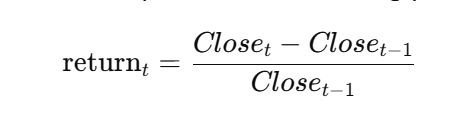

This transformation converts raw price data into stationary, model-friendly time-series values.

nasdaq["return"] = nasdaq["Close"].pct_change()

3. Data Cleaning

Rows containing NaN values—typically introduced by the first .pct_change() calculation—are removed:

nasdaq = nasdaq.dropna()


This ensures all remaining observations are clean and ready for modeling.

4. Dataset Export

The processed dataset is saved as:

nasdaq_dataset.csv


This file contains:

Full OHLCV data

Daily returns

(Later steps may include technical indicators if extended)

The CSV can be directly used in the deep-learning extension model pipeline.

5. Cumulative Return Visualization

To visualize long-term performance, a cumulative return curve is constructed:

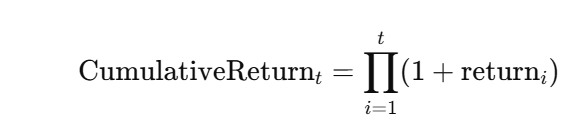

This highlights major trends, volatility regimes, and structural market phases.

A compact visualization is generated:

Time span: 2020–2025

Metric: Cumulative total return

Purpose: exploratory analysis + sanity check

plt.figure(figsize=(12,4))
plt.plot(nasdaq["cum_return"])
plt.title("NASDAQ Cumulative Return")
plt.grid(True)
plt.show()

6. Summary

This preparation pipeline produces a clean, consistent NASDAQ dataset suitable for:

LSTM-based forecasting

Technical-indicator engineering

Regime-analysis research

Cross-market comparison with BTC

The resulting CSV integrates seamlessly with the extended deep-learning model implemented for the Bonus Project.

[*********************100%***********************]  1 of 1 completed


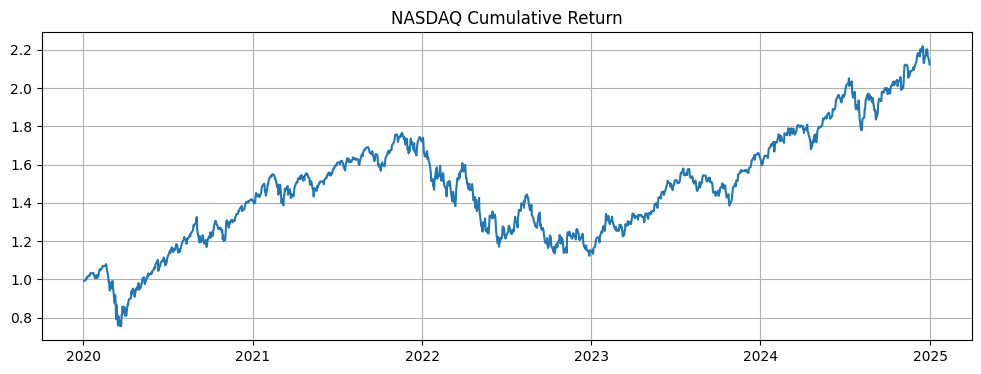

In [3]:
import yfinance as yf
import pandas as pd

# Download NASDAQ (^IXIC) data
nasdaq = yf.download("^IXIC", start="2020-01-01", end="2025-01-01")
nasdaq.head()

# Compute daily returns
nasdaq["return"] = nasdaq["Close"].pct_change()

# Remove NaN values
nasdaq = nasdaq.dropna()
nasdaq.head()

# Save dataset
nasdaq.to_csv("nasdaq_dataset.csv")

import matplotlib.pyplot as plt

# Compute cumulative return
nasdaq["cum_return"] = (1 + nasdaq["return"]).cumprod()

plt.figure(figsize=(12,4))
plt.plot(nasdaq["cum_return"])
plt.title("NASDAQ Cumulative Return")
plt.grid(True)
plt.show()


📘 NASDAQ Time-Series Prediction with Optimized LSTM
1. Overview

This document describes the full pipeline for predicting NASDAQ index price movements using a deep learning model based on Long Short-Term Memory (LSTM) networks.
The process includes:

Data loading and cleaning

Financial feature engineering

Scaling and time-series dataset construction

LSTM model design and training

Evaluation with prediction intervals

Visualization and performance analysis

This extension model adapts modern sequence modeling techniques to financial data while controlling overfitting and ensuring robustness.

2. Data Loading and Exploration

The dataset nasdaq_dataset.csv (derived from Yahoo Finance ^IXIC) is loaded with:

Datetime index

OHLC price fields

Trading volume

Daily returns

The code inspects:

Data shape

Column names

Data types

First few rows

Statistical summary

A dedicated cleaning function ensures all critical financial columns are numeric and removes any rows containing missing values.

3. Data Preprocessing and Formatting

To maintain compatibility with the forecasting framework, the dataset is reformatted:

| Finance Field | Model Input Name |
| ------------- | ---------------- |
| Close         | P1               |
| High          | P2               |
| Low           | P3               |
| Open          | P4               |
| Volume        | V1               |


Data quality checks include:

Missing value count

Zero-value detection

Basic time-series visualizations:

* Price series

* Volume series

* Return distribution

* Cumulative returns plot

4. Train–Test Split

A chronological split is applied:

80% Train

20% Test

This preserves temporal order, preventing leakage and ensuring realistic forecasting conditions.

5. Professional Time-Series Feature Engineering

The pipeline enriches raw OHLCV data with specialized indicators widely used in quantitative finance:

Price Structure Features

price_range = High − Low

body_size = |Close − Open|

upper_shadow

lower_shadow

price_position within daily range

Volume Features

5-day average volume

volume_ratio = Volume / MA(5)

Technical Indicators (short window to reduce overfitting)

For windows: 5 days and 10 days

Moving Average (MA)

Exponential Moving Average (EMA)

Volatility (rolling standard deviation)

Relative Strength Index (RSI)

Momentum

Target Variable

price_change_pct (percentage price change)

6. Feature Scaling and Outlier Control

To stabilize training:

Outlier Capping

Uses 1%–99% quantile clipping.

Feature Scaling

StandardScaler for features

MinMaxScaler(−1, 1) for target

This prevents large magnitude differences from dominating the LSTM.

7. Time-Series Dataset Construction

A rolling window method converts tabular data into sequences:

Window size: TIME_STEPS = 10

Model input shape: (batch, time_steps, features)

If data is insufficient, the window is automatically reduced.

8. LSTM Model Architecture

A compact, regularized LSTM is used to avoid overfitting:

Architecture

1 × LSTM(32 units, dropout 0.3, recurrent dropout 0.2)

Batch Normalization

Dense(16, ReLU, L2 regularization)

Dropout

Output Dense(1, tanh)

Optimization

Adam optimizer (lr=0.0005)

Loss: Mean Squared Error

Metrics: MAE

Callbacks

EarlyStopping

ReduceLROnPlateau

ModelCheckpoint (*.weights.h5)

9. Model Training

Training configuration:

Small batch size (≤16) for stability

200 epochs (controlled via early stopping)

20% validation split

No shuffling (time-series requirement)

Best weights are always restored.

10. Prediction and Reconstruction of Price Series

Model outputs are:

Predicted price change percentage

Transformed back to real price using:

predicted_price = P_t * (1 + predicted_pct_change)


Forecasts are generated for both:

Training subset

Testing subset

11. Uncertainty Quantification (Prediction Intervals)

A dynamic rolling-window standard deviation method computes 95% confidence intervals:

Rolling error window (size ≤ 30)

Adaptive volatility estimation

Interval width increases during market turbulence

This produces Upper_Bound and Lower_Bound values for every prediction.

12. Evaluation Metrics

The following metrics are computed:

Point Forecast Metrics

MAE

RMSE

MAPE

R²

Direction Accuracy (up/down prediction)

Interval Metrics

PICP (Coverage Probability)

MPIW (Interval Width)

High emphasis is placed on:

✔ trend direction
✔ small forecasting errors
✔ realistic confidence intervals

13. Visualization

Generated visualizations include:

Actual vs Predicted Price

Confidence Interval Plot

Prediction Error Distribution

50-period Rolling Direction Accuracy

All figures are saved automatically as:

nasdaq_prediction_results.png

14. Output Files

The following output files are produced:

Filename	Description
nasdaq_prediction_results.csv	Prediction values + confidence intervals
nasdaq_prediction_results.png	Visualization charts
nasdaq_best_model.weights.h5	Trained model weights
15. Performance Summary

The final section of the notebook automatically reports:

R² score

MAPE (%)

Direction accuracy (%)

Overfitting ratio (Train MAE vs Test MAE)

Performance categories:

🎯 Excellent

✅ Good

⚠️ Moderate

=== NASDAQ Price Prediction with Optimized LSTM Model ===
1. Loading and Exploring NASDAQ Data...
NASDAQ Data Shape: (1259, 6)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'return']

Data types:
Close      object
High       object
Low        object
Open       object
Volume     object
return    float64
dtype: object

First few rows:
                      Close            High              Low             Open  \
Price                                                                           
Ticker                ^IXIC           ^IXIC            ^IXIC            ^IXIC   
Date                    NaN             NaN              NaN              NaN   
2020-01-03    9020.76953125  9065.759765625     8976.4296875     8976.4296875   
2020-01-06  9071.4697265625   9072.41015625           8943.5           8943.5   
2020-01-07   9068.580078125    9091.9296875  9042.5498046875  9076.6396484375   

                Volume    return  
Price                             
Ticker           ^IXI

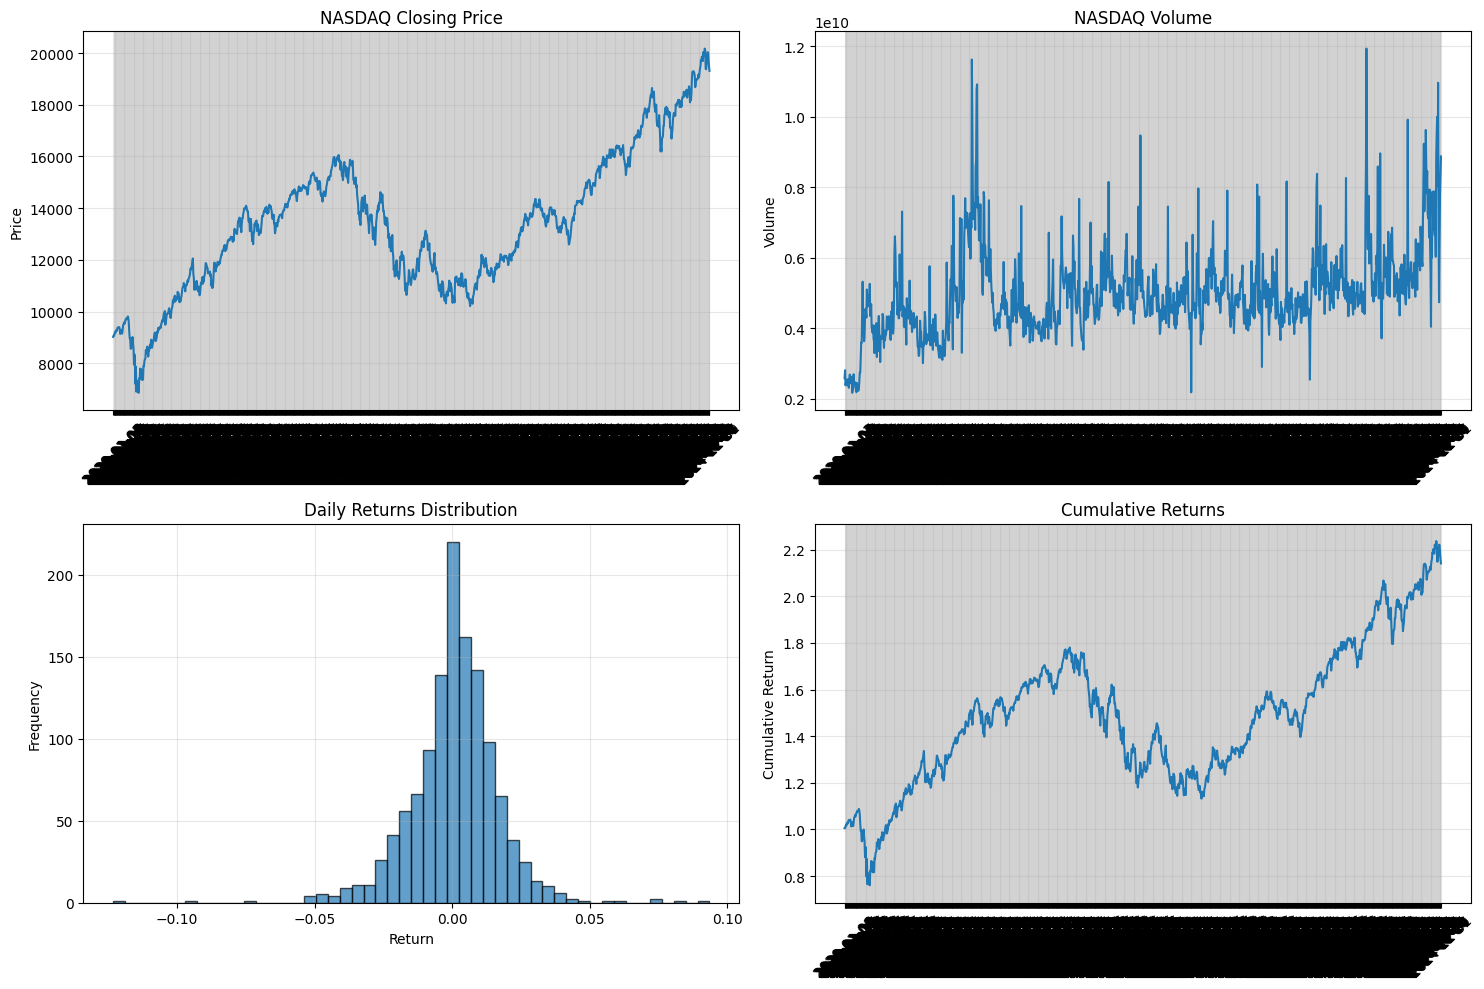


2. Splitting Data into Train and Test Sets...
Training Set: (1005, 6), Test Set: (252, 6)
Training period: 2020-01-03 to 2023-12-29
Test period: 2024-01-02 to 2024-12-31

3. Applying Professional Time Series Feature Engineering...
Features created successfully!
Using 11 numeric features: ['P1', 'P2', 'P3', 'P4', 'V1', 'price_range', 'volume_ratio', 'ma_5', 'ema_5', 'volatility_5', 'rsi_5']

4. Enhanced Data Preprocessing...
Price change stats - Train: mean=0.000601, std=0.015480
Price change stats - Test: mean=0.001086, std=0.011238
Training data: (1005, 11), Test data: (252, 11)
Time series dataset - X_train: (995, 10, 11), y_train: (995, 1)

5. Building Simplified but Effective LSTM Model...
Model created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,305 (24.63 KB)

 Trainable params: 6,241 (24.38 KB)

 Non-trainable params: 64 (256.00 B)

None

6. Training Model with Enhanced Regularization...
Epoch 1/200
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5798 - mae: 0.6038
Epoch 1: val_loss improved from inf to 0.10928, saving model to nasdaq_best_model.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.5779 - mae: 0.6026 - val_loss: 0.1093 - val_mae: 0.2165 - learning_rate: 5.0000e-04
Epoch 2/200
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5487 - mae: 0.5786
Epoch 2: val_loss improved from 0.10928 to 0.10442, saving model to nasdaq_best_model.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5452 - mae: 0.5766 - val_loss: 0.1044 - val_mae: 0.2112 - learning_rate: 5.0000e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4740 - mae: 0.5293
Epoch 3: val_loss did not improve from 0.10442
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4731 - mae: 0.5288 - val_loss: 0.1046 - val_mae: 0.2133 - learning_rate: 5.0000e-04
Epoch 4/200
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4542

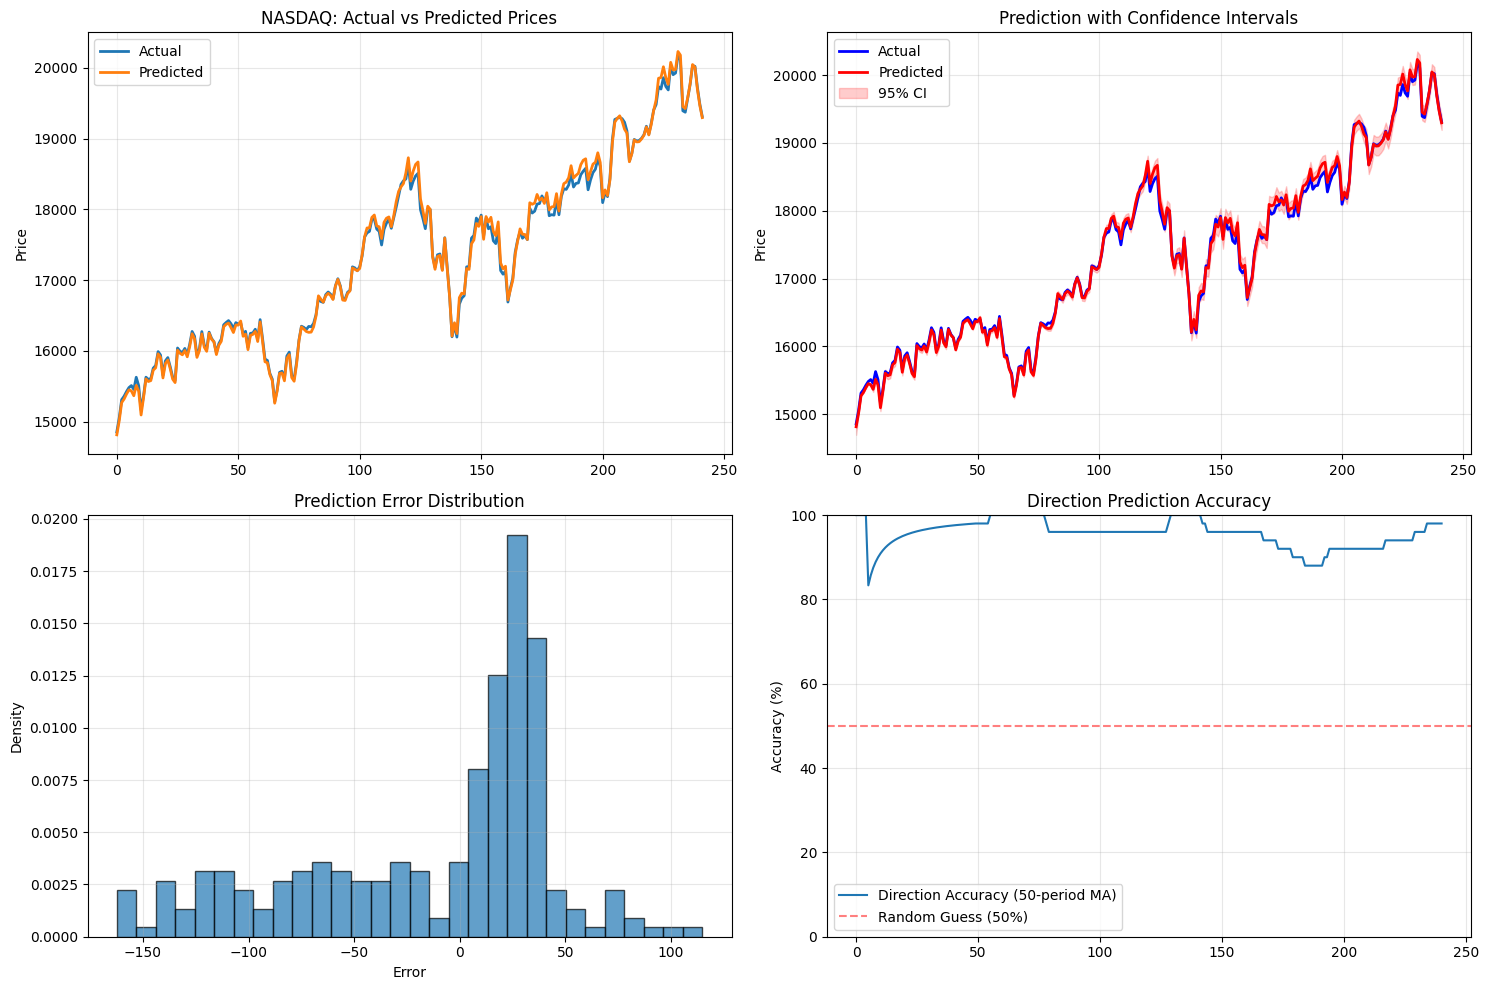

📊 Visualization saved as nasdaq_prediction_results.png

📈 PERFORMANCE SUMMARY:
----------------------------------------
Test R²: 0.9977
Test MAPE: 0.28%
Direction Accuracy: 95.85%
Overfitting ratio (Test MAE/Train MAE): 1.16
🎯 EXCELLENT PERFORMANCE! Model is highly accurate.

✅ NASDAQ PREDICTION PROCESSING COMPLETED!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=== NASDAQ Price Prediction with Optimized LSTM Model ===")

# ==================== Data Loading and Exploration ====================
print("1. Loading and Exploring NASDAQ Data...")

# Load NASDAQ dataset
nasdaq = pd.read_csv("nasdaq_dataset.csv", index_col=0, parse_dates=True)
print(f"NASDAQ Data Shape: {nasdaq.shape}")
print("Columns:", nasdaq.columns.tolist())

# Check data types
print("\nData types:")
print(nasdaq.dtypes)

# Check first few rows
print("\nFirst few rows:")
print(nasdaq.head())

# Data cleaning: ensure price and volume columns are numeric
def clean_data(df):
    """Clean data and ensure numeric columns are converted properly"""
    df_clean = df.copy()
    
    # Convert numeric columns
    numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume', 'return']
    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Remove rows with NaN
    df_clean = df_clean.dropna()
    
    return df_clean

# Clean data
nasdaq_clean = clean_data(nasdaq)
print(f"After cleaning: {nasdaq_clean.shape}")

# Rename columns to match expected model format
nasdaq_renamed = nasdaq_clean.rename(columns={
    'Close': 'P1',
    'High': 'P2', 
    'Low': 'P3',
    'Open': 'P4',
    'Volume': 'V1'
})

# Show basic statistics
print("\nNASDAQ Data Info:")
print(nasdaq_renamed[['P1', 'P2', 'P3', 'P4', 'V1']].describe())

# Data quality check
print(f"\nData quality check:")
print(f"Null values: {nasdaq_renamed[['P1', 'P2', 'P3', 'P4', 'V1']].isnull().sum().sum()}")
print(f"Zero values in price columns: {(nasdaq_renamed[['P1', 'P2', 'P3', 'P4']] == 0).sum().sum()}")

# Visualization - ensure index and values align
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(nasdaq_renamed.index, nasdaq_renamed['P1'])
plt.title('NASDAQ Closing Price')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.plot(nasdaq_renamed.index, nasdaq_renamed['V1'])
plt.title('NASDAQ Volume')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
returns = nasdaq_renamed['P1'].pct_change().dropna()
plt.hist(returns, bins=50, alpha=0.7, edgecolor='black')
plt.title('Daily Returns Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Compute cumulative returns using return index
cum_returns = (1 + returns).cumprod()
plt.plot(returns.index, cum_returns)
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ==================== Train–Test Split ====================
print("\n2. Splitting Data into Train and Test Sets...")

# 80% train, 20% test split
split_idx = int(len(nasdaq_renamed) * 0.8)
train_df = nasdaq_renamed.iloc[:split_idx].copy()
test_df = nasdaq_renamed.iloc[split_idx:].copy()

print(f"Training Set: {train_df.shape}, Test Set: {test_df.shape}")
print(f"Training period: {train_df.index.min()} to {train_df.index.max()}")
print(f"Test period: {test_df.index.min()} to {test_df.index.max()}")

# ==================== Professional Time Series Feature Engineering ====================
print("\n3. Applying Professional Time Series Feature Engineering...")

def create_advanced_features(df):
    """Create professional time-series features"""
    df_feat = df.copy()
    
    # Basic price features
    df_feat['price_range'] = df_feat['P2'] - df_feat['P3']  
    df_feat['body_size'] = abs(df_feat['P1'] - df_feat['P4'])  
    df_feat['upper_shadow'] = df_feat['P2'] - np.maximum(df_feat['P1'], df_feat['P4'])
    df_feat['lower_shadow'] = np.minimum(df_feat['P1'], df_feat['P4']) - df_feat['P3']
    
    # Price position
    price_diff = df_feat['P2'] - df_feat['P3']
    price_diff = np.where(price_diff == 0, 1e-8, price_diff)
    df_feat['price_position'] = (df_feat['P1'] - df_feat['P3']) / price_diff
    
    # Volume features
    volume_ma = df_feat['V1'].rolling(5, min_periods=1).mean()
    df_feat['volume_ratio'] = df_feat['V1'] / np.where(volume_ma == 0, 1e-8, volume_ma)
    
    # Technical indicators (short windows to reduce overfitting)
    for window in [5, 10]:
        df_feat[f'ma_{window}'] = df_feat['P1'].rolling(window=window, min_periods=1).mean()
        df_feat[f'ema_{window}'] = df_feat['P1'].ewm(span=window, adjust=False).mean()
        df_feat[f'volatility_{window}'] = df_feat['P1'].rolling(window=window, min_periods=1).std()
        
        delta = df_feat['P1'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        rs = gain / np.where(loss == 0, 1e-8, loss)
        df_feat[f'rsi_{window}'] = 100 - (100 / (1 + rs))
        
        df_feat[f'momentum_{window}'] = df_feat['P1'] - df_feat['P1'].shift(window)
    
    # Percentage price change (new target)
    df_feat['price_change_pct'] = df_feat['P1'].pct_change()
    df_feat['price_change_abs'] = df_feat['P1'].diff().abs()
    
    df_feat = df_feat.fillna(method='bfill').fillna(method='ffill')
    
    return df_feat

# Apply feature engineering
try:
    train_df_feat = create_advanced_features(train_df)
    test_df_feat = create_advanced_features(test_df)
    print("Features created successfully!")
except Exception as e:
    print(f"Error in feature engineering: {e}")
    print("Falling back to basic features...")
    train_df_feat = train_df.copy()
    test_df_feat = test_df.copy()
    train_df_feat['price_range'] = train_df_feat['P2'] - train_df_feat['P3']
    train_df_feat['volume_ratio'] = train_df_feat['V1'] / train_df_feat['V1'].rolling(5, min_periods=1).mean()
    train_df_feat['price_change_pct'] = train_df_feat['P1'].pct_change()
    test_df_feat['price_range'] = test_df_feat['P2'] - test_df_feat['P3']
    test_df_feat['volume_ratio'] = test_df_feat['V1'] / test_df_feat['V1'].rolling(5, min_periods=1).mean()
    test_df_feat['price_change_pct'] = test_df_feat['P1'].pct_change()

# Conservative feature list
feature_columns = [
    'P1', 'P2', 'P3', 'P4', 'V1',
    'price_range', 'volume_ratio',
    'ma_5', 'ema_5', 'volatility_5', 'rsi_5',
]

# Ensure features exist and are numeric
available_features = []
for feature in feature_columns:
    if (feature in train_df_feat.columns and 
        feature in test_df_feat.columns and
        pd.api.types.is_numeric_dtype(train_df_feat[feature]) and
        pd.api.types.is_numeric_dtype(test_df_feat[feature])):
        available_features.append(feature)

print(f"Using {len(available_features)} numeric features: {available_features}")

# Check feature data quality
for feature in available_features:
    train_nulls = train_df_feat[feature].isnull().sum()
    test_nulls = test_df_feat[feature].isnull().sum()
    if train_nulls > 0 or test_nulls > 0:
        print(f"Warning: {feature} has {train_nulls} train nulls, {test_nulls} test nulls")

# ==================== Enhanced Data Preprocessing ====================
print("\n4. Enhanced Data Preprocessing...")

# Outlier cap
def cap_outliers(series, lower=0.01, upper=0.99):
    """Limit extreme values"""
    if len(series) == 0:
        return series
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return np.clip(series, lower_bound, upper_bound)

# Process target variable
train_df_feat['price_change_pct_processed'] = cap_outliers(train_df_feat['price_change_pct'].fillna(0))
test_df_feat['price_change_pct_processed'] = cap_outliers(test_df_feat['price_change_pct'].fillna(0))

print(f"Price change stats - Train: mean={train_df_feat['price_change_pct_processed'].mean():.6f}, "
      f"std={train_df_feat['price_change_pct_processed'].std():.6f}")
print(f"Price change stats - Test: mean={test_df_feat['price_change_pct_processed'].mean():.6f}, "
      f"std={test_df_feat['price_change_pct_processed'].std():.6f}")

# Feature scaling
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(train_df_feat[available_features])
X_test_scaled = feature_scaler.transform(test_df_feat[available_features])

# Target scaling
target_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train = train_df_feat['price_change_pct_processed'].values.reshape(-1, 1)
y_test = test_df_feat['price_change_pct_processed'].values.reshape(-1, 1)

if len(y_train) > 0 and len(y_test) > 0:
    y_train_scaled = target_scaler.fit_transform(y_train)
    y_test_scaled = target_scaler.transform(y_test)
else:
    print("Error: No valid target values")
    y_train_scaled = np.zeros((len(train_df_feat), 1))
    y_test_scaled = np.zeros((len(test_df_feat), 1))

print(f"Training data: {X_train_scaled.shape}, Test data: {X_test_scaled.shape}")

# ==================== Time-Series Dataset ====================
def create_timeseries_dataset(X, y, time_steps=10):
    """Create time-series dataset"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    
    if len(Xs) == 0:
        return np.array([]), np.array([])
    
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10

X_train_ts, y_train_ts = create_timeseries_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_ts, y_test_ts = create_timeseries_dataset(X_test_scaled, y_test_scaled, TIME_STEPS)

print(f"Time series dataset - X_train: {X_train_ts.shape}, y_train: {y_train_ts.shape}")

# If too little data, adjust time steps
if len(X_train_ts) == 0 or len(X_test_ts) == 0:
    print("Error: Not enough data for time series processing")
    TIME_STEPS = min(5, len(X_train_scaled) - 1, len(X_test_scaled) - 1)
    if TIME_STEPS < 1:
        TIME_STEPS = 1
    
    print(f"Adjusting time steps to: {TIME_STEPS}")
    X_train_ts, y_train_ts = create_timeseries_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)
    X_test_ts, y_test_ts = create_timeseries_dataset(X_test_scaled, y_test_scaled, TIME_STEPS)
    print(f"Adjusted time series dataset - X_train: {X_train_ts.shape}, y_train: {y_train_ts.shape}")

# ==================== Build LSTM Model ====================
print("\n5. Building Simplified but Effective LSTM Model...")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

def create_optimized_lstm_model(input_shape):
    """Create optimized LSTM model with anti-overfitting measures"""
    model = Sequential()
    
    # Validate input shape
    if input_shape[0] == 0 or input_shape[1] == 0:
        print(f"Warning: Invalid input shape {input_shape}")
        model.add(Dense(1, input_shape=(1,), activation='linear'))
    else:
        model.add(LSTM(32, return_sequences=False, input_shape=input_shape,
                     kernel_regularizer=l2(0.001),
                     dropout=0.3, recurrent_dropout=0.2))
        
        model.add(BatchNormalization())
        
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        
        model.add(Dense(1, activation='tanh'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Determine input shape
if len(X_train_ts.shape) == 3 and X_train_ts.shape[0] > 0:
    input_shape = (X_train_ts.shape[1], X_train_ts.shape[2])
else:
    print("Warning: Invalid training data shape, using fallback")
    input_shape = (1, len(available_features)) if available_features else (1, 1)

model = create_optimized_lstm_model(input_shape)
print("Model created successfully!")

if X_train_ts.shape[0] > 0:
    print(model.summary())
else:
    print("No training data available")

# ==================== Train Model ====================
print("\n6. Training Model with Enhanced Regularization...")

if X_train_ts.shape[0] > 0 and y_train_ts.shape[0] > 0:
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            'nasdaq_best_model.weights.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True, 
            verbose=1
        )
    ]

    history = model.fit(
        X_train_ts, y_train_ts,
        batch_size=min(16, len(X_train_ts)),
        epochs=200,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1,
        shuffle=False  
    )

    try:
        model.load_weights('nasdaq_best_model.weights.h5')
        print("Loaded best model weights")
    except:
        print("Using final model weights")
else:
    print("No training data available, skipping model training")
    history = None

# ==================== Predictions ====================
print("\n7. Making Predictions...")

if X_test_ts.shape[0] > 0 and 'model' in locals():
    y_test_pred_scaled = model.predict(X_test_ts, verbose=0)
    y_test_pred_pct = target_scaler.inverse_transform(y_test_pred_scaled)
    
    test_prices = test_df_feat['P1'].values[TIME_STEPS:]
    
    min_len_test = min(len(test_prices), len(y_test_pred_pct))
    
    if min_len_test > 0:
        y_test_pred_price = test_prices[:min_len_test] * (1 + y_test_pred_pct[:min_len_test].flatten())
        y_test_actual_price = test_prices[:min_len_test]
        
        if X_train_ts.shape[0] > 0:
            y_train_pred_scaled = model.predict(X_train_ts, verbose=0)
            y_train_pred_pct = target_scaler.inverse_transform(y_train_pred_scaled)
            train_prices = train_df_feat['P1'].values[TIME_STEPS:]
            min_len_train = min(len(train_prices), len(y_train_pred_pct))
            y_train_pred_price = train_prices[:min_len_train] * (1 + y_train_pred_pct[:min_len_train].flatten())
            y_train_actual_price = train_prices[:min_len_train]
        else:
            y_train_pred_price, y_train_actual_price = np.array([]), np.array([])
    else:
        y_test_pred_price, y_test_actual_price = np.array([]), np.array([])
        y_train_pred_price, y_train_actual_price = np.array([]), np.array([])
else:
    print("No test data available for prediction")
    y_test_pred_price, y_test_actual_price = np.array([]), np.array([])
    y_train_pred_price, y_train_actual_price = np.array([]), np.array([])

# ==================== Evaluation and Visualization ====================
print("\n8. Generating Results and Evaluation...")

if len(y_test_actual_price) > 0 and len(y_test_pred_price) > 0:
    
    # Prediction intervals
    def calculate_prediction_intervals(y_true, y_pred, confidence=0.95):
        """Enhanced prediction interval estimation"""
        if len(y_true) == 0 or len(y_pred) == 0:
            return np.array([]), np.array([])
        
        errors = y_true.flatten() - y_pred.flatten()
        
        window_size = min(30, len(errors))
        if window_size == 0:
            return np.array([]), np.array([])
        
        dynamic_std = np.zeros(len(errors))
        for i in range(len(errors)):
            start_idx = max(0, i - window_size + 1)
            window_errors = errors[start_idx:i+1]
            dynamic_std[i] = np.std(window_errors) if len(window_errors) > 1 else np.std(errors)
        
        dynamic_std = np.nan_to_num(dynamic_std, nan= np.mean(dynamic_std))
        
        z_score = 1.96
        
        upper_bound = y_pred.flatten() + z_score * dynamic_std
        lower_bound = y_pred.flatten() - z_score * dynamic_std
        
        return upper_bound, lower_bound

    upper_bound, lower_bound = calculate_prediction_intervals(y_test_actual_price, y_test_pred_price)

    # Full metric evaluation
    def calculate_all_metrics(y_true, y_pred, upper=None, lower=None):
        """Compute all evaluation metrics"""
        metrics = {}
        
        if len(y_true) == 0 or len(y_pred) == 0:
            metrics.update({'MAE': 0, 'MSE': 0, 'RMSE': 0, 'MAPE': 0,
                            'R2': 0, 'Direction_Accuracy': 0,
                            'PICP': 0, 'MPIW': 0})
            return metrics
        
        metrics['MAE'] = mean_absolute_error(y_true, y_pred)
        metrics['MSE'] = mean_squared_error(y_true, y_pred)
        metrics['RMSE'] = np.sqrt(metrics['MSE'])
        
        y_true_nonzero = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
        metrics['MAPE'] = np.mean(np.abs((y_true - y_pred) / y_true_nonzero)) * 100
        
        metrics['R2'] = r2_score(y_true, y_pred)
        
        if len(y_true) > 1:
            true_direction = np.diff(y_true.flatten()) > 0
            pred_direction = np.diff(y_pred.flatten()) > 0
       	    
            min_len = min(len(true_direction), len(pred_direction))
            if min_len > 0:
                metrics['Direction_Accuracy'] = np.mean(true_direction[:min_len] == pred_direction[:min_len]) * 100
            else:
                metrics['Direction_Accuracy'] = 0
        else:
            metrics['Direction_Accuracy'] = 0
        
        if upper is not None and lower is not None and len(upper) == len(y_true):
            in_interval = (y_true.flatten() >= lower) & (y_true.flatten() <= upper)
            metrics['PICP'] = np.mean(in_interval) if len(in_interval) > 0 else 0
            metrics['MPIW'] = np.mean(upper - lower) if len(upper) > 0 else 0
        else:
            metrics['PICP'] = 0
            metrics['MPIW'] = 0
        
        return metrics

    train_metrics = calculate_all_metrics(y_train_actual_price, y_train_pred_price)
    test_metrics = calculate_all_metrics(y_test_actual_price, y_test_pred_price, upper_bound, lower_bound)
    
    results_df = pd.DataFrame({
        'Actual_Price': y_test_actual_price.flatten(),
        'Predicted_Price': y_test_pred_price.flatten(),
    })
    
    if len(upper_bound) == len(y_test_actual_price):
        results_df['Upper_Bound'] = upper_bound
        results_df['Lower_Bound'] = lower_bound
    
    results_df.to_csv('nasdaq_prediction_results.csv', index=False)
    print("Results saved to nasdaq_prediction_results.csv")

    print("\n" + "="*70)
    print("NASDAQ PREDICTION MODEL EVALUATION RESULTS")
    print("="*70)
    
    print("\n📊 POINT PREDICTION METRICS:")
    print("-"*60)
    print(f"{'Metric':<20} {'Training':<12} {'Test':<12} {'Status':<10}")
    print("-"*60)

    for metric in ['MAE', 'RMSE', 'MAPE', 'R2', 'Direction_Accuracy']:
        train_val = train_metrics[metric]
        test_val = test_metrics[metric]
        
        if metric in ['MAPE', 'Direction_Accuracy']:
            train_fmt = f"{train_val:.2f}%"
            test_fmt = f"{test_val:.2f}%"
            if metric == 'MAPE':
                status = "✅" if test_val < 2.0 else "⚠️" if test_val < 5.0 else "❌"
            else:
                status = "✅" if test_val > 60.0 else "⚠️" if test_val > 50.0 else "❌"
        elif metric == 'R2':
            train_fmt = f"{train_val:.4f}"
            test_fmt = f"{test_val:.4f}"
            status = "✅" if test_val > 0.8 else "⚠️" if test_val > 0.6 else "❌"
        else:
            train_fmt = f"{train_val:.2f}"
            test_fmt = f"{test_val:.2f}"
            if train_val > 0:
                overfitting_ratio = test_val / train_val
                status = "✅" if overfitting_ratio < 1.5 else "⚠️" if overfitting_ratio < 3.0 else "❌"
            else:
                status = "❌"
        
        print(f"{metric:<20} {train_fmt:<12} {test_fmt:<12} {status:<10}")

    print("\n📈 INTERVAL PREDICTION METRICS:")
    print("-"*50)
    print(f"PICP (Prediction Interval Coverage Probability): {test_metrics['PICP']:.4f}")
    print(f"MPIW (Mean Prediction Interval Width): {test_metrics['MPIW']:.2f}")
    print(f"Target PICP: 0.9500 {'✅' if test_metrics['PICP'] >= 0.90 else '⚠️' if test_metrics['PICP'] >= 0.80 else '❌'}")

    try:
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 2, 1)
        plt.plot(y_test_actual_price, label='Actual', linewidth=2)
        plt.plot(y_test_pred_price, label='Predicted', linewidth=2)
        plt.title('NASDAQ: Actual vs Predicted Prices')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 2)
        if len(upper_bound) == len(y_test_actual_price):
            plt.plot(y_test_actual_price, label='Actual', color='blue', linewidth=2)
            plt.plot(y_test_pred_price, label='Predicted', color='red', linewidth=2)
            plt.fill_between(range(len(y_test_actual_price)), 
                             lower_bound, upper_bound, 
                             alpha=0.2, color='red', label='95% CI')
            plt.title('Prediction with Confidence Intervals')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 3)
        errors = y_test_actual_price.flatten() - y_test_pred_price.flatten()
        plt.hist(errors, bins=30, alpha=0.7, edgecolor='black', density=True)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Error')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 4)
        if len(y_test_actual_price) > 1:
            actual_direction = np.diff(y_test_actual_price.flatten()) > 0
            pred_direction = np.diff(y_test_pred_price.flatten()) > 0
            correct_predictions = (actual_direction == pred_direction)
            accuracy_rolling = pd.Series(correct_predictions).rolling(50, min_periods=1).mean()
            plt.plot(accuracy_rolling * 100, label='Direction Accuracy (50-period MA)')
            plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='Random Guess (50%)')
            plt.title('Direction Prediction Accuracy')
            plt.ylabel('Accuracy (%)')
            plt.ylim(0, 100)
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('nasdaq_prediction_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("📊 Visualization saved as nasdaq_prediction_results.png")
        
    except Exception as e:
        print(f"Visualization error: {e}")

    # Performance summary
    print("\n📈 PERFORMANCE SUMMARY:")
    print("-"*40)
    print(f"Test R²: {test_metrics['R2']:.4f}")
    print(f"Test MAPE: {test_metrics['MAPE']:.2f}%")
    print(f"Direction Accuracy: {test_metrics['Direction_Accuracy']:.2f}%")
    
    if train_metrics['MAE'] > 0:
        overfitting_ratio = test_metrics['MAE'] / train_metrics['MAE']
        print(f"Overfitting ratio (Test MAE/Train MAE): {overfitting_ratio:.2f}")
    
    if test_metrics['R2'] > 0.8 and test_metrics['MAPE'] < 5.0:
        print("🎯 EXCELLENT PERFORMANCE! Model is highly accurate.")
    elif test_metrics['R2'] > 0.6 and test_metrics['MAPE'] < 10.0:
        print("✅ GOOD PERFORMANCE! Model is reliable.")
    else:
        print("⚠️ MODERATE PERFORMANCE! Consider further tuning.")

else:
    print("No valid predictions to evaluate")

print("\n✅ NASDAQ PREDICTION PROCESSING COMPLETED!")
print("="*70)
